In [71]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [2]:
call = pd.read_csv('Dataset.csv')
df = pd.DataFrame(call)
df.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'document type', 'posting_id', 'area_business', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

In [3]:
# As we can see in the list of columns 'document_create_date' is twice, so we drop one.

df_drop = df.drop(['document_create_date.1'], axis=1)

# finding nan values 
df_drop.isna().sum()

business_code               0
cust_number                 0
name_customer               0
clear_date               4175
buisness_year               0
doc_id                      0
posting_date                0
document_create_date        0
due_in_date                 0
invoice_currency            0
document type               0
posting_id                  0
area_business           50000
total_open_amount           0
baseline_create_date        0
cust_payment_terms          0
invoice_id                 10
isOpen                      0
dtype: int64

In [4]:
# From the above sum we can see 'area_business' is totally useless as it has null values for all 50k data rows.
df_drop1 = df_drop.drop(['area_business'], axis = 1)

# There are 4175 rows with clear date missing which is useful in finding payment delay predictions, so these rows are useless.
df_drop2 = df_drop1.dropna(axis = 0, how ='any') # additionally removing those null values too for invoice_id
df_drop2.shape
# df_drop2.isna().sum()

(45815, 17)

## Creating Target Column

In [5]:
def change_date(x_type):
    x = str(x_type)
    year = int(x[0:4])
    month = int(x[4:6])
    day = int(x[6:])
    return dt.datetime(year, month, day)

In [6]:
# year/month/date
# due date() - clear date(day/month/year)
# generating due date into readable format.
df_drop2['due_date'] = df_drop2['due_in_date'].apply(change_date)
df_drop2['clear_date']= pd.to_datetime(df_drop2['clear_date']) 

# Creating target variable
df_drop2['target'] = (df_drop2['clear_date'] - df_drop2['due_date']).dt.days
# df_drop2.head(5) target value +ve means there was a delay in payment.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [7]:
df_drop2['document_create_date'] = df_drop2['document_create_date'].apply(change_date)
df_drop2['baseline_create_date'] = df_drop2['baseline_create_date'].apply(change_date)

print(pd.to_datetime(df_drop2['document_create_date']).min()) 
print(pd.to_datetime(df_drop2['document_create_date']).max())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


2018-12-27 00:00:00
2020-02-28 00:00:00


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
# Splitting the initial dataframe into train and test
# So in this case we can consider last 3 months for test set.
x_train = df_drop2[df_drop2['document_create_date'] <= '2020-01-01'].copy()
x_test = df_drop2[df_drop2['document_create_date'] > '2020-01-01'].copy()

In [9]:
x_train.describe()

,buisness_year,doc_id,due_in_date,posting_id,total_open_amount,invoice_id,isOpen,target
count,40128.000000,4.012800e+04,4.012800e+04,40128.0,4.012800e+04,4.012800e+04,40128.0,40128.000000
mean,2019.008548,2.011554e+09,2.019083e+07,1.0,3.240339e+04,2.011554e+09,0.0,-5.438995
std,0.092059,2.772913e+08,1.162742e+03,0.0,4.074218e+04,2.772913e+08,0.0,88.401850
min,2019.000000,1.928502e+09,2.018123e+07,1.0,6.500000e-01,1.928502e+09,0.0,-319.000000
25%,2019.000000,1.929099e+09,2.019042e+07,1.0,4.838005e+03,1.929099e+09,0.0,-5.000000
50%,2019.000000,1.929613e+09,2.019071e+07,1.0,1.736832e+04,1.929613e+09,0.0,0.000000
75%,2019.000000,1.930024e+09,2.019101e+07,1.0,4.666770e+04,1.930024e+09,0.0,4.000000
max,2020.000000,2.960605e+09,2.020023e+07,1.0,1.501474e+06,2.960605e+09,0.0,319.000000


In [10]:
x_test.describe()

,buisness_year,doc_id,due_in_date,posting_id,total_open_amount,invoice_id,isOpen,target
count,5687.0,5.687000e+03,5.687000e+03,5687.0,5687.000000,5.687000e+03,5687.0,5687.000000
mean,2020.0,2.003980e+09,2.020022e+07,1.0,31721.408788,2.003980e+09,0.0,47.573765
std,0.0,2.636071e+08,2.207017e+02,0.0,38389.021783,2.636071e+08,0.0,87.483215
min,2020.0,1.930339e+09,2.019113e+07,1.0,10.890000,1.930339e+09,0.0,-117.000000
25%,2020.0,1.930410e+09,2.020020e+07,1.0,4695.995000,1.930410e+09,0.0,-1.000000
50%,2020.0,1.930468e+09,2.020022e+07,1.0,17379.400000,1.930468e+09,0.0,2.000000
75%,2020.0,1.930535e+09,2.020030e+07,1.0,46900.695000,1.930535e+09,0.0,59.000000
max,2020.0,2.960617e+09,2.020062e+07,1.0,702254.070000,2.960617e+09,0.0,302.000000


In [11]:
# we get to see that posting_id and isOpen bboth have just one value for all data, so we remove them.
X_train = x_train.drop(['posting_id', 'posting_id', 'document type'], axis = 1)
X_test = x_test.drop(['posting_id', 'posting_id', 'document type'], axis = 1)

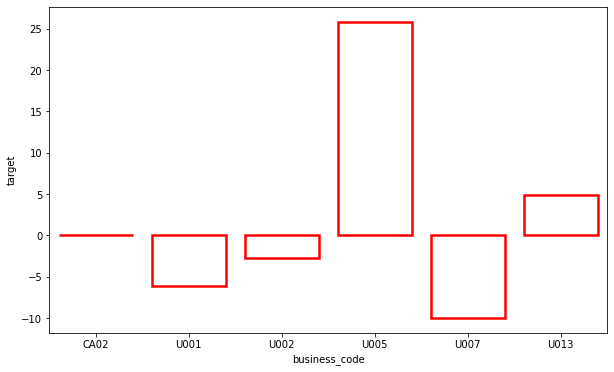

In [12]:
temp = pd.DataFrame(X_train.groupby(['business_code'], axis=0, as_index=False)['target'].mean())
plt.figure(figsize=(10,6))
sns.barplot(x="business_code", y="target",data=temp,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".4", edgecolor="red")

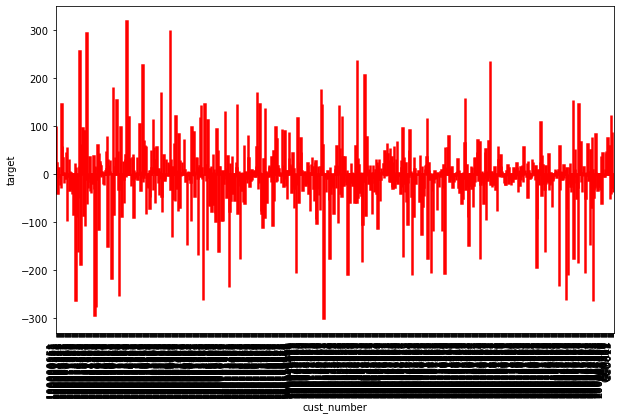

In [13]:
temp = pd.DataFrame(X_train.groupby(['cust_number'], axis=0, as_index=False)['target'].mean())
plt.figure(figsize=(10,6))
graph = sns.barplot(x="cust_number", y="target",data=temp,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".4", edgecolor="red")

graph = graph.set_xticklabels(graph.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')

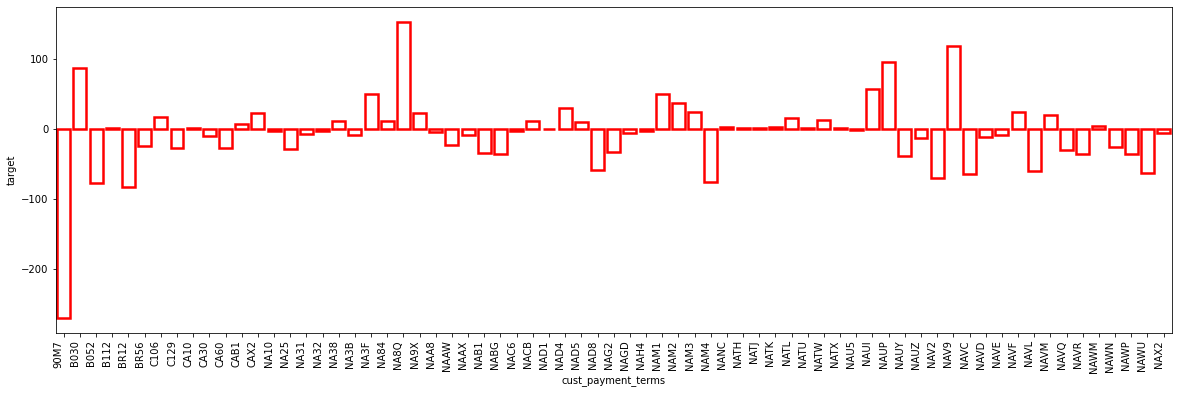

In [14]:
temp = pd.DataFrame(X_train.groupby(['cust_payment_terms'], axis=0, as_index=False)['target'].mean())
plt.figure(figsize=(20,6))
graph = sns.barplot(x="cust_payment_terms", y="target",data=temp,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".4", edgecolor="red")

graph = graph.set_xticklabels(graph.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')

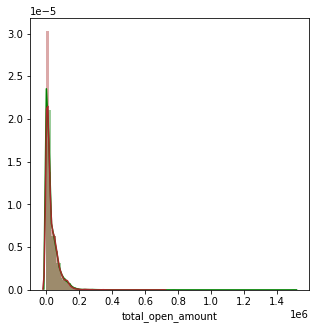

In [15]:
plt.figure(figsize=(5,5))
plt.figure(1)
sns.distplot(X_train['total_open_amount'],color='green')
sns.distplot(X_test['total_open_amount'],color='brown')

In [16]:
# The graph is Right Skewed: log transformation is needed.

def Transform(x):
    return np.log(x)

X_train['total_open_amount'] = X_train['total_open_amount'].apply(Transform)
X_test['total_open_amount'] = X_test['total_open_amount'].apply(Transform)

In [17]:
X_train['cust_number'].nunique()

1038

In [18]:
X_test['cust_number'].nunique()

520

In [19]:
# print(dict(X_train['cust_number'].value_counts()))
# taking individuals till CCU013

In [20]:
# print(dict(X_test['cust_number'].value_counts()))

In [21]:
# Dropping those columns which don't contribute anything for predictions.
X_train = X_train.drop([ 'due_in_date', 'isOpen'], axis = 1)
X_test = X_test.drop([ 'due_in_date', 'isOpen'], axis = 1)

In [22]:
X_train.head(1)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,due_date,target
0,U001,200726979,BJ'S in,2020-01-13,2020,1930330859,29-12-2019,2019-12-28,USD,4.080246,2019-12-29,NAA8,1.930331e+09,2020-01-13,0


In [23]:
#print(dict(X_train['cust_number'].value_counts()))
ref = dict(X_train['cust_number'].value_counts())


X_train['cust_number_new'] = X_train['cust_number'].map(ref)

In [24]:
ref1 = dict(X_test['cust_number'].value_counts())


X_test['cust_number_new'] = X_test['cust_number'].map(ref1)

In [25]:
# It is clear that U002 afterwards all business codes are meager so we take it as others.

X_train = X_train.replace(['U002', 'U005', 'U007'], 'other')
X_test = X_test.replace(['U002', 'U005', 'U007'], 'other')

business = pd.get_dummies(X_train['business_code'])
business1 = pd.get_dummies(X_test['business_code'])
# Above in the business_code column we can see they are categorical ones, so we make new feature
# out of them 
X_train = pd.concat([X_train, business], axis=1)
X_test = pd.concat([X_test, business1], axis=1)

X_train.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,due_date,target,cust_number_new,CA02,U001,U013,other
0,U001,200726979,BJ'S in,2020-01-13,2020,1930330859,29-12-2019,2019-12-28,USD,4.080246,2019-12-29,NAA8,1.930331e+09,2020-01-13,0,1577,0,1,0,0
2,U001,200434439,BAUGH SU co,2019-12-31,2019,1930188160,22-11-2019,2019-11-23,USD,11.123802,2019-11-22,NA32,1.930188e+09,2019-12-24,7,78,0,1,0,0
3,U001,200769623,WAL-MAR foundation,2019-06-25,2019,1929472295,13-06-2019,2019-06-11,USD,6.592496,2019-06-13,NAH4,1.929472e+09,2019-06-28,-3,9748,0,1,0,0
4,U001,200769623,WAL-MAR associates,2019-05-14,2019,1929243669,03-05-2019,2019-05-02,USD,10.488820,2019-05-03,NAH4,1.929244e+09,2019-05-18,-4,9748,0,1,0,0
5,U001,200735528,ASSOCIA trust,2019-08-30,2019,1929735102,14-08-2019,2019-08-12,USD,11.303382,2019-08-14,NAA8,1.929735e+09,2019-08-29,1,35,0,1,0,0


In [26]:
ref2 = dict(X_train['cust_payment_terms'].value_counts())


X_train['cust_payment_terms_new'] = X_train['cust_payment_terms'].map(ref2)

In [27]:
ref3 = dict(X_test['cust_payment_terms'].value_counts())


X_test['cust_payment_terms_new'] = X_test['cust_payment_terms'].map(ref3)

In [28]:
X_train.head(2)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,...,cust_payment_terms,invoice_id,due_date,target,cust_number_new,CA02,U001,U013,other,cust_payment_terms_new
0,U001,200726979,BJ'S in,2020-01-13,2020,1930330859,29-12-2019,2019-12-28,USD,4.080246,...,NAA8,1.930331e+09,2020-01-13,0,1577,0,1,0,0,16074
2,U001,200434439,BAUGH SU co,2019-12-31,2019,1930188160,22-11-2019,2019-11-23,USD,11.123802,...,NA32,1.930188e+09,2019-12-24,7,78,0,1,0,0,634


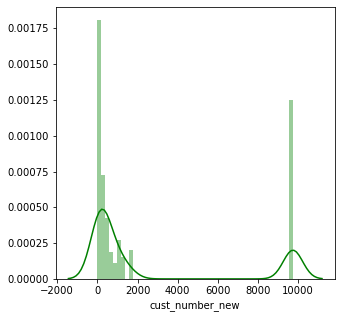

In [29]:
plt.figure(figsize=(5,5))
plt.figure(1)
sns.distplot(X_train['cust_number_new'],color='green')

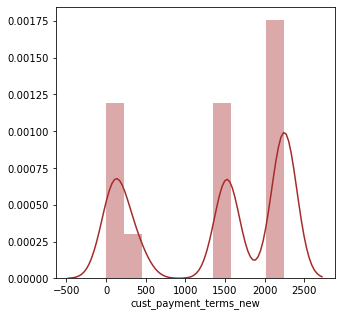

In [30]:
plt.figure(figsize=(5,5))
plt.figure(1)
sns.distplot(X_test['cust_payment_terms_new'],color='brown')

In [31]:
X_train['cust_number_new'].skew()

1.1682284000491865

In [32]:
X_train['cust_payment_terms_new'].skew()

-0.42534301669998836

In [33]:
from scipy.stats import boxcox

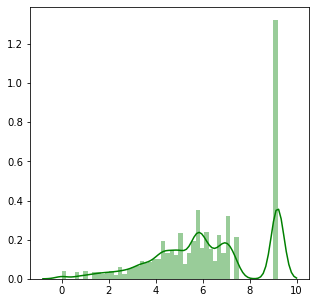

In [34]:
"""
lambda = -1. is a reciprocal transform.
lambda = -0.5 is a reciprocal square root transform.
lambda = 0.0 is a log transform.
lambda = 0.5 is a square root transform.
lambda = 1.0 is no transform.
"""

df = boxcox(X_train['cust_number_new'], 0.0)
# df1 = boxcox(df, 0.0)
plt.figure(figsize=(5,5))
plt.figure(1)
sns.distplot(df,color='green')

In [35]:
X_train['cust_number_new'] = df

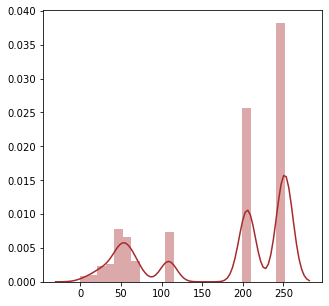

In [36]:
df1 = boxcox(X_train['cust_payment_terms_new'], 0.5)
# df1 = boxcox(df, 0.0)
plt.figure(figsize=(5,5))
plt.figure(1)
sns.distplot(df1,color='brown')

In [37]:
X_train['cust_payment_terms_new'] = df1

In [38]:
df2 = boxcox(X_test['cust_number_new'], 0.0)
X_test['cust_number_new'] = df2

In [39]:
df3 = boxcox(X_test['cust_payment_terms_new'], 0.0)
X_test['cust_payment_terms_new'] = df3

In [40]:
# creating new data from document_create_date.

In [41]:
import datetime as dt

In [42]:
X_train['year'] = X_train['document_create_date'].dt.year
X_train['month'] = X_train['document_create_date'].dt.month
X_train['day'] = X_train['document_create_date'].dt.day
X_train['week'] = X_train['document_create_date'].dt.week
X_train['which_day'] = X_train['document_create_date'].dt.dayofweek
X_train['quarter'] = X_train['document_create_date'].dt.quarter

In [43]:
X_train.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'invoice_currency', 'total_open_amount', 'baseline_create_date',
       'cust_payment_terms', 'invoice_id', 'due_date', 'target',
       'cust_number_new', 'CA02', 'U001', 'U013', 'other',
       'cust_payment_terms_new', 'year', 'month', 'day', 'week', 'which_day',
       'quarter'],
      dtype='object')

In [44]:
invoice_dic = {'USD': 1, 'CAD': 0}
X_train['invoice_currency'] = X_train['invoice_currency'].map(invoice_dic)

In [45]:
X_test['year'] = X_test['document_create_date'].dt.year
X_test['month'] = X_test['document_create_date'].dt.month
X_test['day'] = X_test['document_create_date'].dt.day
X_test['week'] = X_test['document_create_date'].dt.week
X_test['which_day'] = X_test['document_create_date'].dt.dayofweek
X_test['quarter'] = X_test['document_create_date'].dt.quarter

X_test['invoice_currency'] = X_test['invoice_currency'].map(invoice_dic)

In [47]:
X_train1 = X_train.drop(['business_code', 'cust_number', 'name_customer', 'doc_id', 'cust_payment_terms'
                        , 'invoice_id'], axis = 1)

X_test1 = X_test.drop(['business_code', 'cust_number', 'name_customer', 'doc_id', 'cust_payment_terms'
                        , 'invoice_id'], axis = 1)

In [48]:
X_train1['clear_date']= pd.to_datetime(X_train1['clear_date']) 

# Creating target variable
X_train1['expected_target'] = (X_train1['due_date'] - X_train1['baseline_create_date']).dt.days

X_test1['clear_date']= pd.to_datetime(X_test1['clear_date']) 

# Creating target variable
X_test1['expected_target'] = (X_test1['due_date'] - X_test1['baseline_create_date']).dt.days

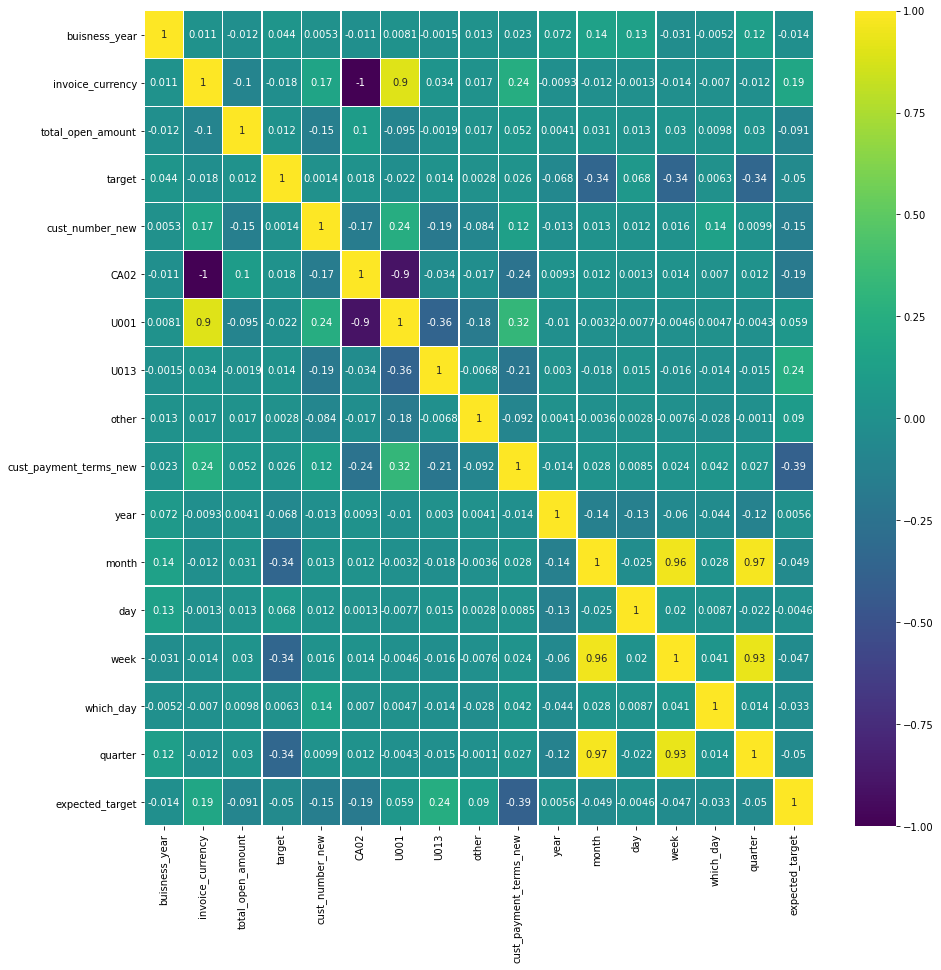

In [49]:
# X_final.columns
plt.figure(figsize=(15,15))
sns.heatmap(X_train1.corr(),annot=True,cmap='viridis',linewidths=.5)

In [50]:
# dropping columns that won't help in predictions. Note on feature has high correlation with target variable.
X_final = X_train1.drop(['clear_date', 'posting_date', 'document_create_date', 'baseline_create_date','due_date'], axis = 1)

X_final_test = X_test1.drop(['clear_date', 'posting_date', 'document_create_date', 'baseline_create_date','due_date'], axis = 1)

In [51]:
X_final = X_final.drop(['CA02', 'week', 'U001'], axis = 1)

X_final_test = X_final_test.drop(['CA02', 'week', 'U001'], axis = 1)

In [59]:
X_final['target'] = X_train1['target']

In [60]:
y = X_final['target']
X_final = X_final.drop(['target'], axis = 1)
Xtrain ,Xtest, ytrain, ytest = train_test_split(X_final, y, test_size = 0.1, random_state=0)

In [61]:
l = list(np.isfinite(ytrain))
print([x for x in l if x == False])

[]


In [62]:
lp = list(np.isfinite(Xtrain))
print([x for x in lp if x == False])

[]


In [78]:
random_model = RandomForestRegressor(n_estimators=500, random_state = 42)

In [79]:
#Fit
random_model.fit(Xtrain, ytrain)

y_pred3 = random_model.predict(Xtest)

#Checking the accuracy
random_model_accuracy = round(random_model.score(Xtrain, ytrain)*100,2)
print(round(random_model_accuracy, 2), '%')

93.69 %


In [80]:
#Checking the accuracy
random_model_accuracy1 = round(random_model.score(Xtest, ytest)*100,2)
print(round(random_model_accuracy1, 2), '%')

52.77 %


In [73]:
# Standardizing the data - it was better before lol.

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
xtrain = sc.fit_transform(Xtrain)
xtest = sc.transform(Xtest)

In [74]:
random_model.fit(xtrain, ytrain)
y_pred = random_model.predict(xtest)

In [75]:
#Checking the accuracy
random_model_accuracy2 = round(random_model.score(xtrain, ytrain)*100,2)
print(round(random_model_accuracy2, 2), '%')

93.69 %


In [76]:
#Checking the accuracy
random_model_accuracy3 = round(random_model.score(xtest, ytest)*100,2)
print(round(random_model_accuracy3, 2), '%')

52.63 %


In [77]:
#  Using Scikit-Learn’s RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly 
# sample from the grid, performing K-Fold CV with each combination of values.

In [81]:
# parameters of random forest regressor.
print(random_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [82]:
"""
n_estimators = number of trees in the foreset
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
bootstrap = method for sampling data points (with or without replacement)
"""

from sklearn.model_selection import RandomizedSearchCV

In [84]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 700, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 55, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 255, 311, 366, 422, 477, 533, 588, 644, 700], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 14, 19, 23, 28, 32, 37, 41, 46, 50, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [85]:
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

# n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(xtrain, ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 44.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 14, 19, 23, 28, 32,
                                                      37, 41, 46, 50, 55,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 255, 311, 366,
                                                         422, 477, 533, 588,
                                                         644, 700]},
                   random_state=42, verbose=2)

In [86]:
rf_random.best_params_

{'n_estimators': 588,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [94]:
random_model1 = RandomForestRegressor(n_estimators = 588, min_samples_split = 10, min_samples_leaf = 1, max_features = 'sqrt',
                                      max_depth = None, bootstrap = True)

In [97]:
#Fit
random_model1.fit(Xtrain, ytrain)

y_pred3 = random_model1.predict(Xtest)

#Checking the accuracy
random_model_accuracy = round(random_model1.score(Xtrain, ytrain)*100,2)
print(round(random_model_accuracy, 2), '%')

76.3 %


In [98]:
#Checking the accuracy
random_model_accuracy1 = round(random_model1.score(Xtest, ytest)*100,2)
print(round(random_model_accuracy1, 2), '%')

55.04 %


In [99]:
# the first two models were overfitting, but this randomCV model is not, gives a little better accuracy than before.